In [56]:
using LinearAlgebra
using Arpack
using Random
using Plots

gr(size=(1800,1600))

Plots.GRBackend()

In [57]:
function OracleSubspace(A,b,ε,q,k,Pi,x_true)
# approximation of the smallest eigenvalues.
eigvals,eigvecs = eigen(inv(I - ε*A))
# Sort eigenvalues in descending order
sorted_indices = sortperm(real(eigvals), rev = true)
sorted_eigvecs = real(eigvecs[:, sorted_indices])

# Get the q-1 largest eigenvectors
top_eigvecs = sorted_eigvecs[:,1:q-1]
#invA = invA[:,:q-1]

error_arr = zeros(q)

y = zeros(size(b))

for j=1:q
    y += ε*b - ε*A*y
    full_subspace = hcat(y,top_eigvecs)
    Q,R = qr(full_subspace)
    Q = Matrix(Q)

    AQ = A*Q
    c = (Q'*AQ)\(Q'*b)

    x_approx = Q*c

    error_arr[j] = norm(x_approx-x_true)/norm(x_true)
end

return error_arr
end

OracleSubspace (generic function with 1 method)

In [58]:
function RandomStarting(A,b,ε,q,k,Pi,x_true)
n = size(A,1)
# Ensure that ε is small enough so that I - ε*A has
# spectral radius < 1
eigenvalues = eigvals(I - ε*A)
spectral_radius = maximum(abs.(eigenvalues))
if spectral_radius >= 1
    throw(ArgumentError("Choose a smaller ε such that spectral radius of I - εA
    is less than 1"))
end

Y = zeros(n,k)
Y[:,2:end] = Pi

error_arr = zeros(q)

for j=1:q
    Y[:,2:end] = (I - ε*A)*Y[:,2:end]
    Y[:,1] += ε*b - ε*A*Y[:,1]

    Q,R = qr(Y)

    Q = Matrix(Q) # skinny qr
    
    AQ = A*Q
    c = (Q'*AQ)\(Q'*b)

    x_approx = Q*c

    error_arr[j] = norm(x_approx-x_true)/norm(x_true)
end

return error_arr
end

RandomStarting (generic function with 1 method)

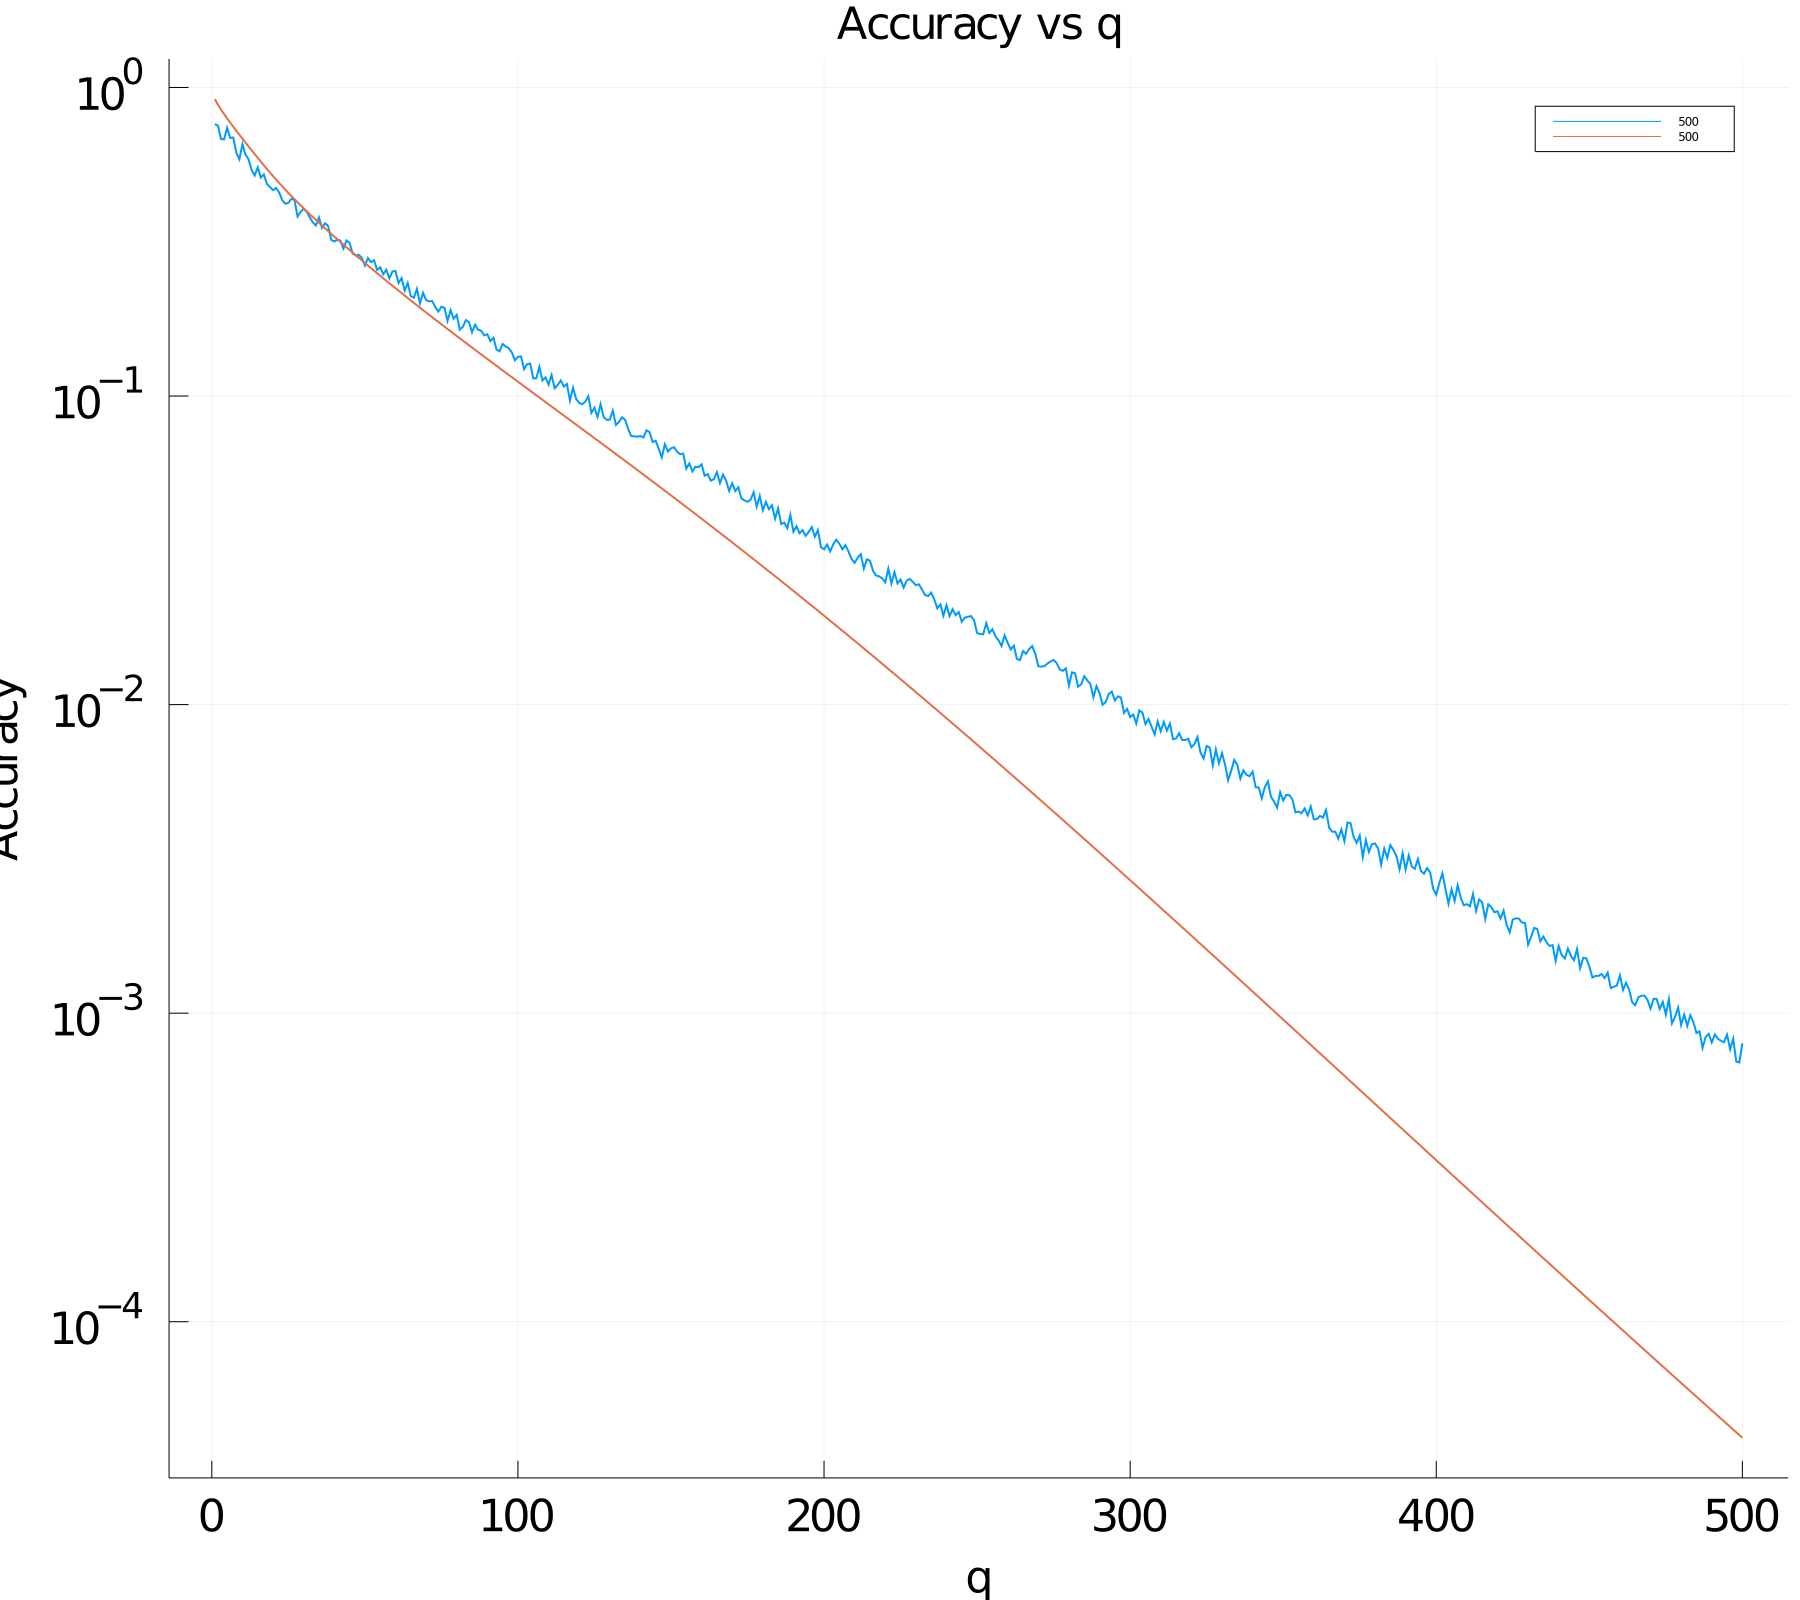

In [59]:
# main
n = 1000
λ = @. 10 + (1:n)
A = randn(n,n) + diagm(λ)
b = randn(n)
ε = 0.001
q_arr = 500
k = 10
x_true = A\b
# random sketch matrix
Pi = randn(n,k-1)

p = plot()
for q=q_arr
    oracle_error = OracleSubspace(A,b,ε,q,k,Pi,x_true)
    plot!(1:length(oracle_error),oracle_error,
        title="Accuracy vs q",
        yaxis=:log10,
        xlab="q",
        ylab="Accuracy",
        label=q,
        linewidth=2,
        titlefontsize=30,
        guidefontsize=30,
        tickfontsize=30)
end

for q=q_arr
    algo_error = RandomStarting(A,b,ε,q,k,Pi,x_true)
    plot!(1:length(algo_error),algo_error,
        title="Accuracy vs q",
        yaxis=:log10,
        xlab="q",
        ylab="Accuracy",
        label=q,
        linewidth=2,
        titlefontsize=30,
        guidefontsize=30,
        tickfontsize=30)
end

display(p)
